In [1]:
import torch
import os

from torchvision import datasets

import numpy as np
from glob import glob

from PIL import Image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import gc

In [2]:
filePath = 'train_images_100'


In [3]:
#Preprocessing
preprocess = {
    filePath : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4282, 0.4800, 0.5347], std = [0.1421, 0.1444, 0.158])
    ]),
    
    'test_images_100': transforms.Compose([
        transforms.Resize(224), #Resize to image size
        transforms.CenterCrop(224), #Tensor size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4282, 0.4800, 0.5347], std = [0.1421, 0.1444, 0.158])
        
    ])
    
}

image_path = "./"

#Load the images
images = {i: datasets.ImageFolder(os.path.join(image_path, i), preprocess[i])
          for i in [filePath, 'test_images_100']}
loader = {x: torch.utils.data.DataLoader(images[x], batch_size = 32, shuffle = True, num_workers = 0) 
                for x in [filePath, 'test_images_100']}

In [4]:
#Making the CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1), 
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), 
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) 
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) 
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2) 
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(2,2)
        )
                        
        self.fc1 = nn.Linear(in_features=7*7*256, out_features=1024)
        self.dropout = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.fc3 = nn.Linear(in_features=512, out_features=len(images[filePath].classes))
        
    #Forward function
    def forward(self, x):
        logits = self.layer1(x)
        logits = self.layer2(logits)
        logits = self.layer3(logits)
        logits = self.layer4(logits)
        logits = self.layer5(logits)
                
        logits = logits.view(logits.size(0), -1)
        
        logits = self.fc1(logits)
        logits = self.dropout(logits)
        logits = self.fc2(logits)
        logits = F.log_softmax(self.fc3(logits), -1)
        
        return logits
    

In [5]:
#Loss Function
model = CNN()

if (torch.cuda.is_available()):
    torch.cuda.empty_cache()
    
    gc.collect()
    
    model.cuda()
    
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
num_epochs = 25

In [7]:
#Training the model        
for epoch in range(num_epochs):
    train_loss = 0.0
    
    model.train()
    for i, (images, labels) in enumerate (loader[filePath]):
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()
        
        optimizer.zero_grad()    
        
        logits = model(images)
        
        loss = criterion(logits, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.detach().item()
        
    model.eval()
        
    print('Epoch: %d | Loss: %.4f |' %(epoch, train_loss / i))
        

c:\Users\tilak\anaconda3\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0 | Loss: 3.9173 |
Epoch: 1 | Loss: 3.9226 |
Epoch: 2 | Loss: 3.9072 |
Epoch: 3 | Loss: 3.9107 |
Epoch: 4 | Loss: 3.9023 |
Epoch: 5 | Loss: 3.9075 |
Epoch: 6 | Loss: 3.8923 |
Epoch: 7 | Loss: 3.8907 |
Epoch: 8 | Loss: 3.8907 |
Epoch: 9 | Loss: 3.8704 |


In [8]:
test_acc = 0.0
correct = 0
total = 0
for i, (images, labels) in enumerate (loader['test_images_100']):
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
    
    outputs = model(images)
    loss = criterion(outputs, labels)
    pred = torch.max(outputs, 1)[1]
    
    correct = correct + np.sum(np.squeeze(pred.eq(labels.data.view_as(pred))).cpu().numpy())
    total = total + images.size(0)
    
print ("Test Accuracy: %2d%% (%2d/%2d)" % (100.0 * correct / total, correct, total))

Test Accuracy: 21% (21/100)


In [9]:
from IPython.display import Image as Image2, display

images = {i: datasets.ImageFolder(os.path.join(image_path, i), preprocess[i])
          for i in [filePath, 'test_images_100']}
species = images[filePath].classes


def species_dolphin_whale(path):
    image = Image.open(path)
    
    preprocess = transforms.Compose([transforms.Resize(224), #Resize to image size
                                    transforms.CenterCrop(224), #Tensor size
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])])
    
    tensor = preprocess(image).float()
    
    tensor.unsqueeze_(0)
    
    tensor = torch.autograd.Variable(tensor)
    
    if torch.cuda.is_available():
        tensor = torch.autograd.Variable(tensor.cuda())
        
    model.eval()
    output = model(tensor)
    output = output.cpu()
    
    return species[output.data.numpy().argmax()]
    

Predicted below: bottlenose_dolphin


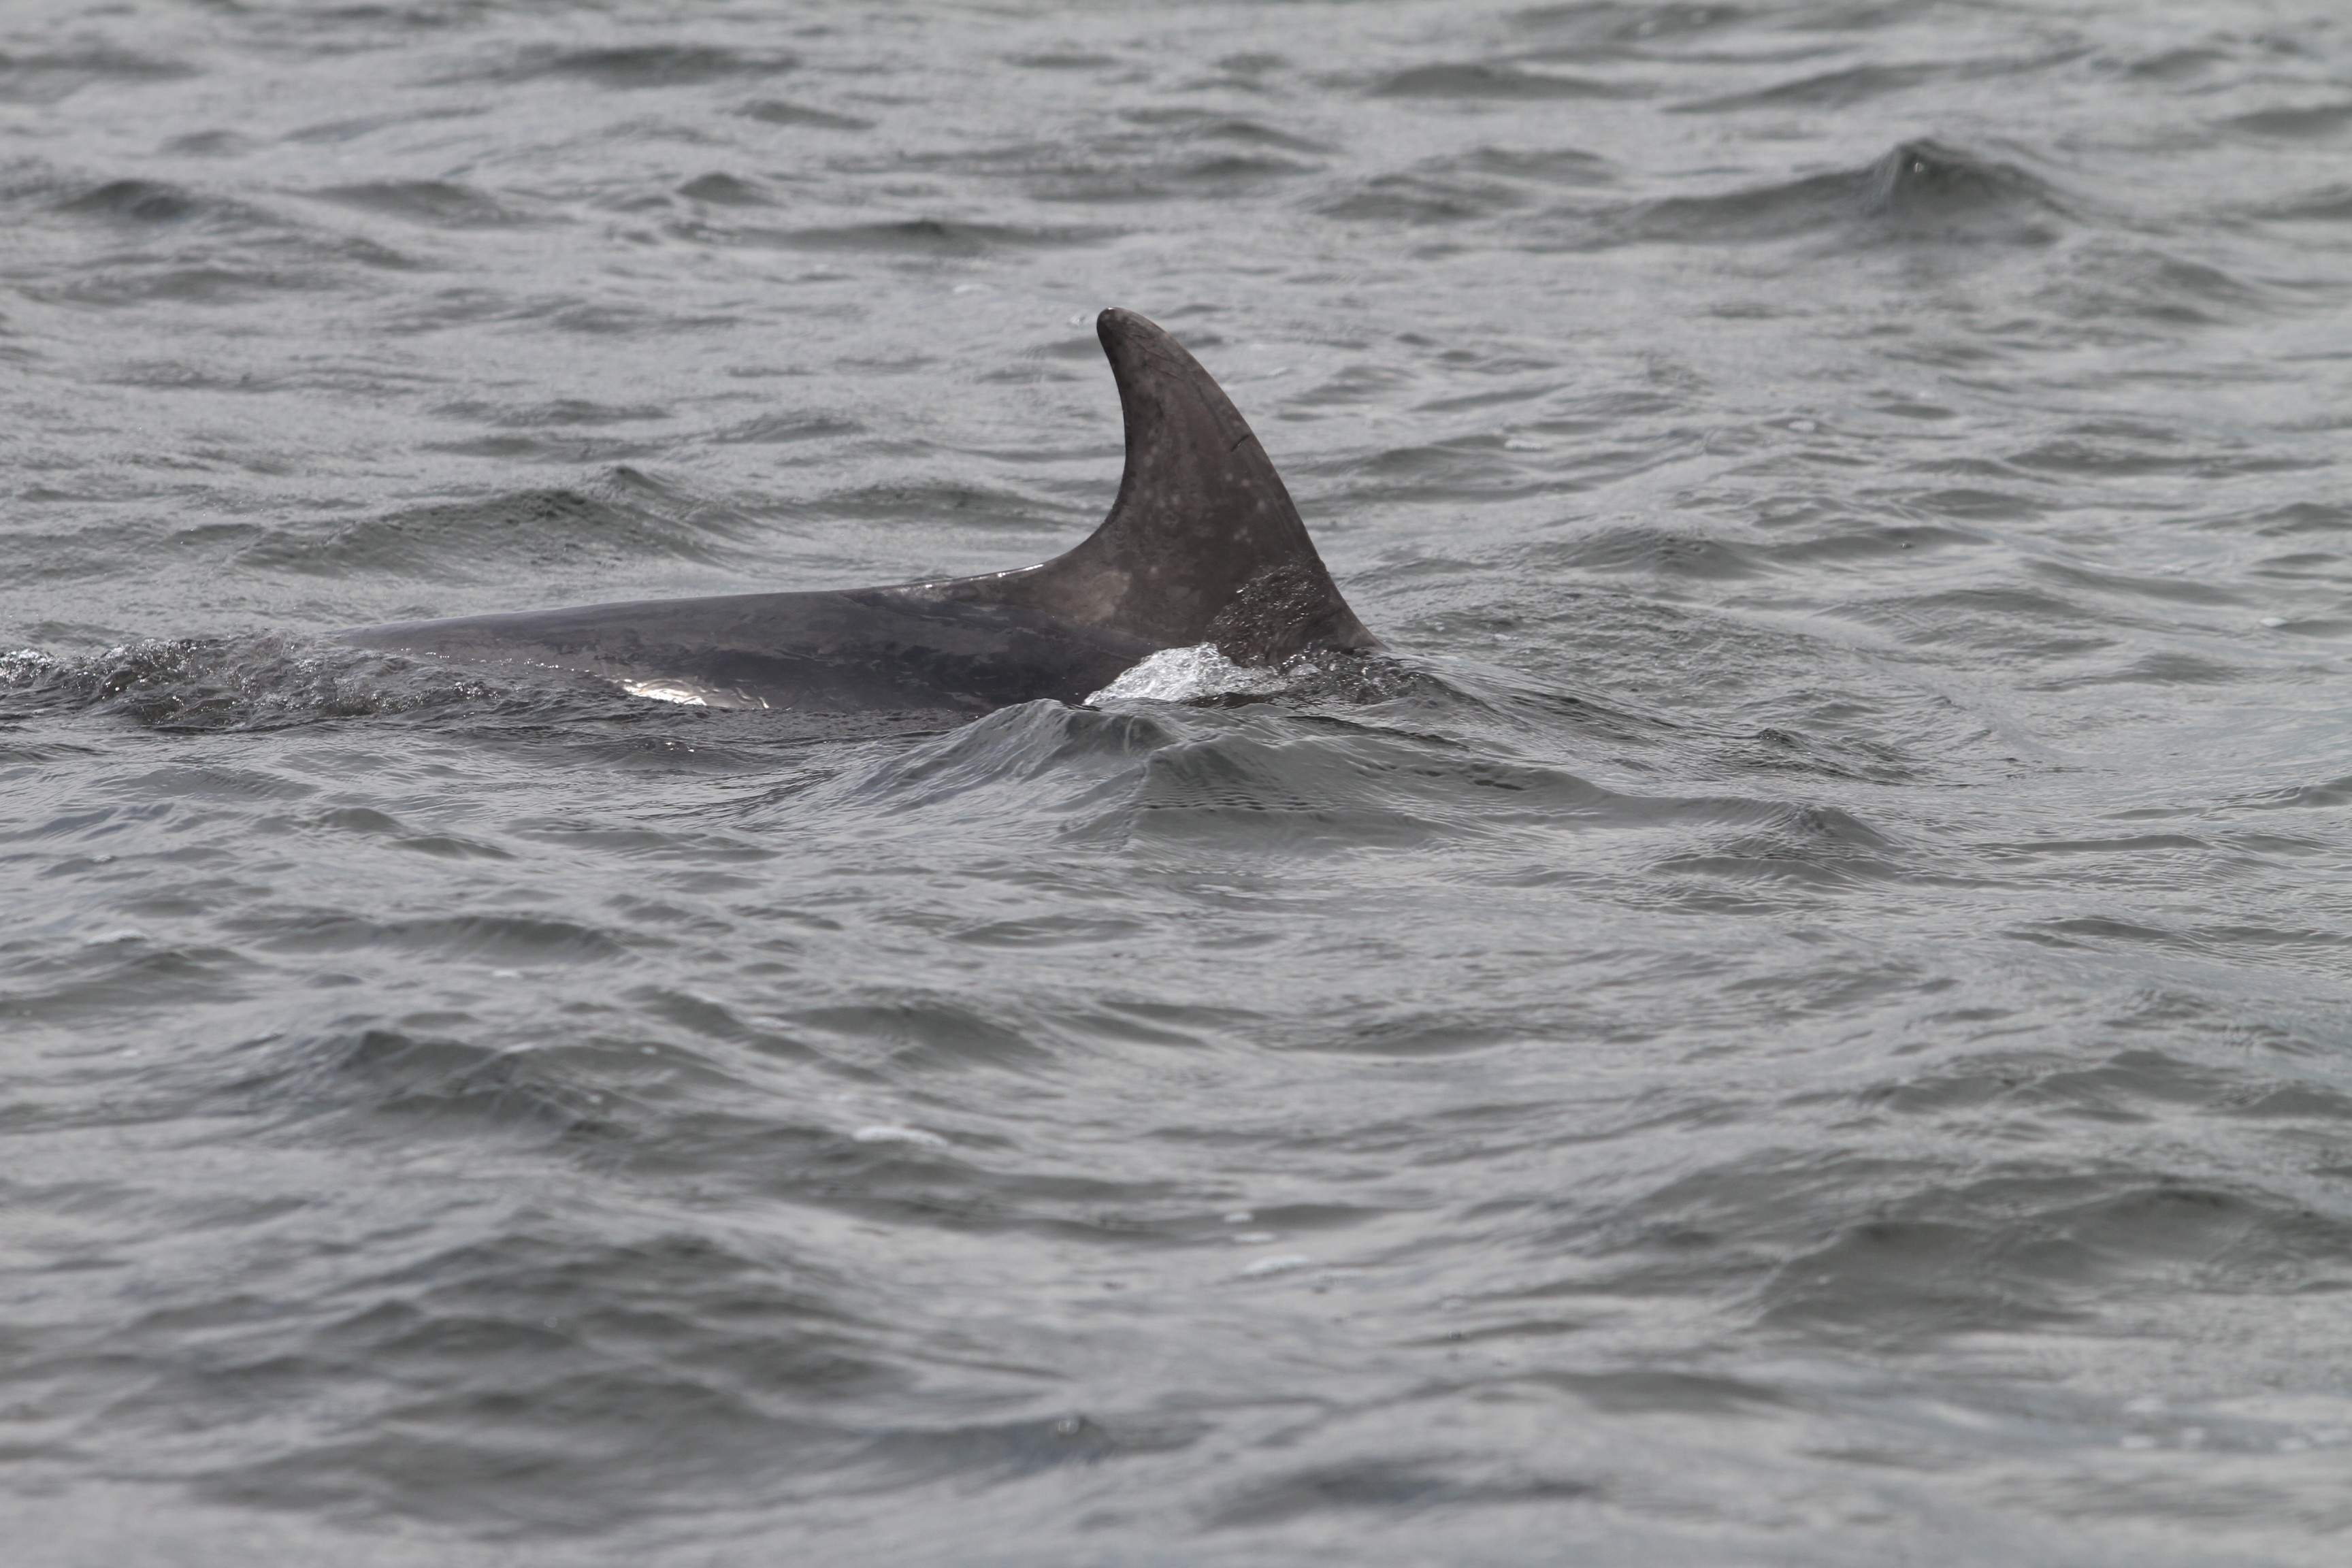

Predicted below: bottlenose_dolphin


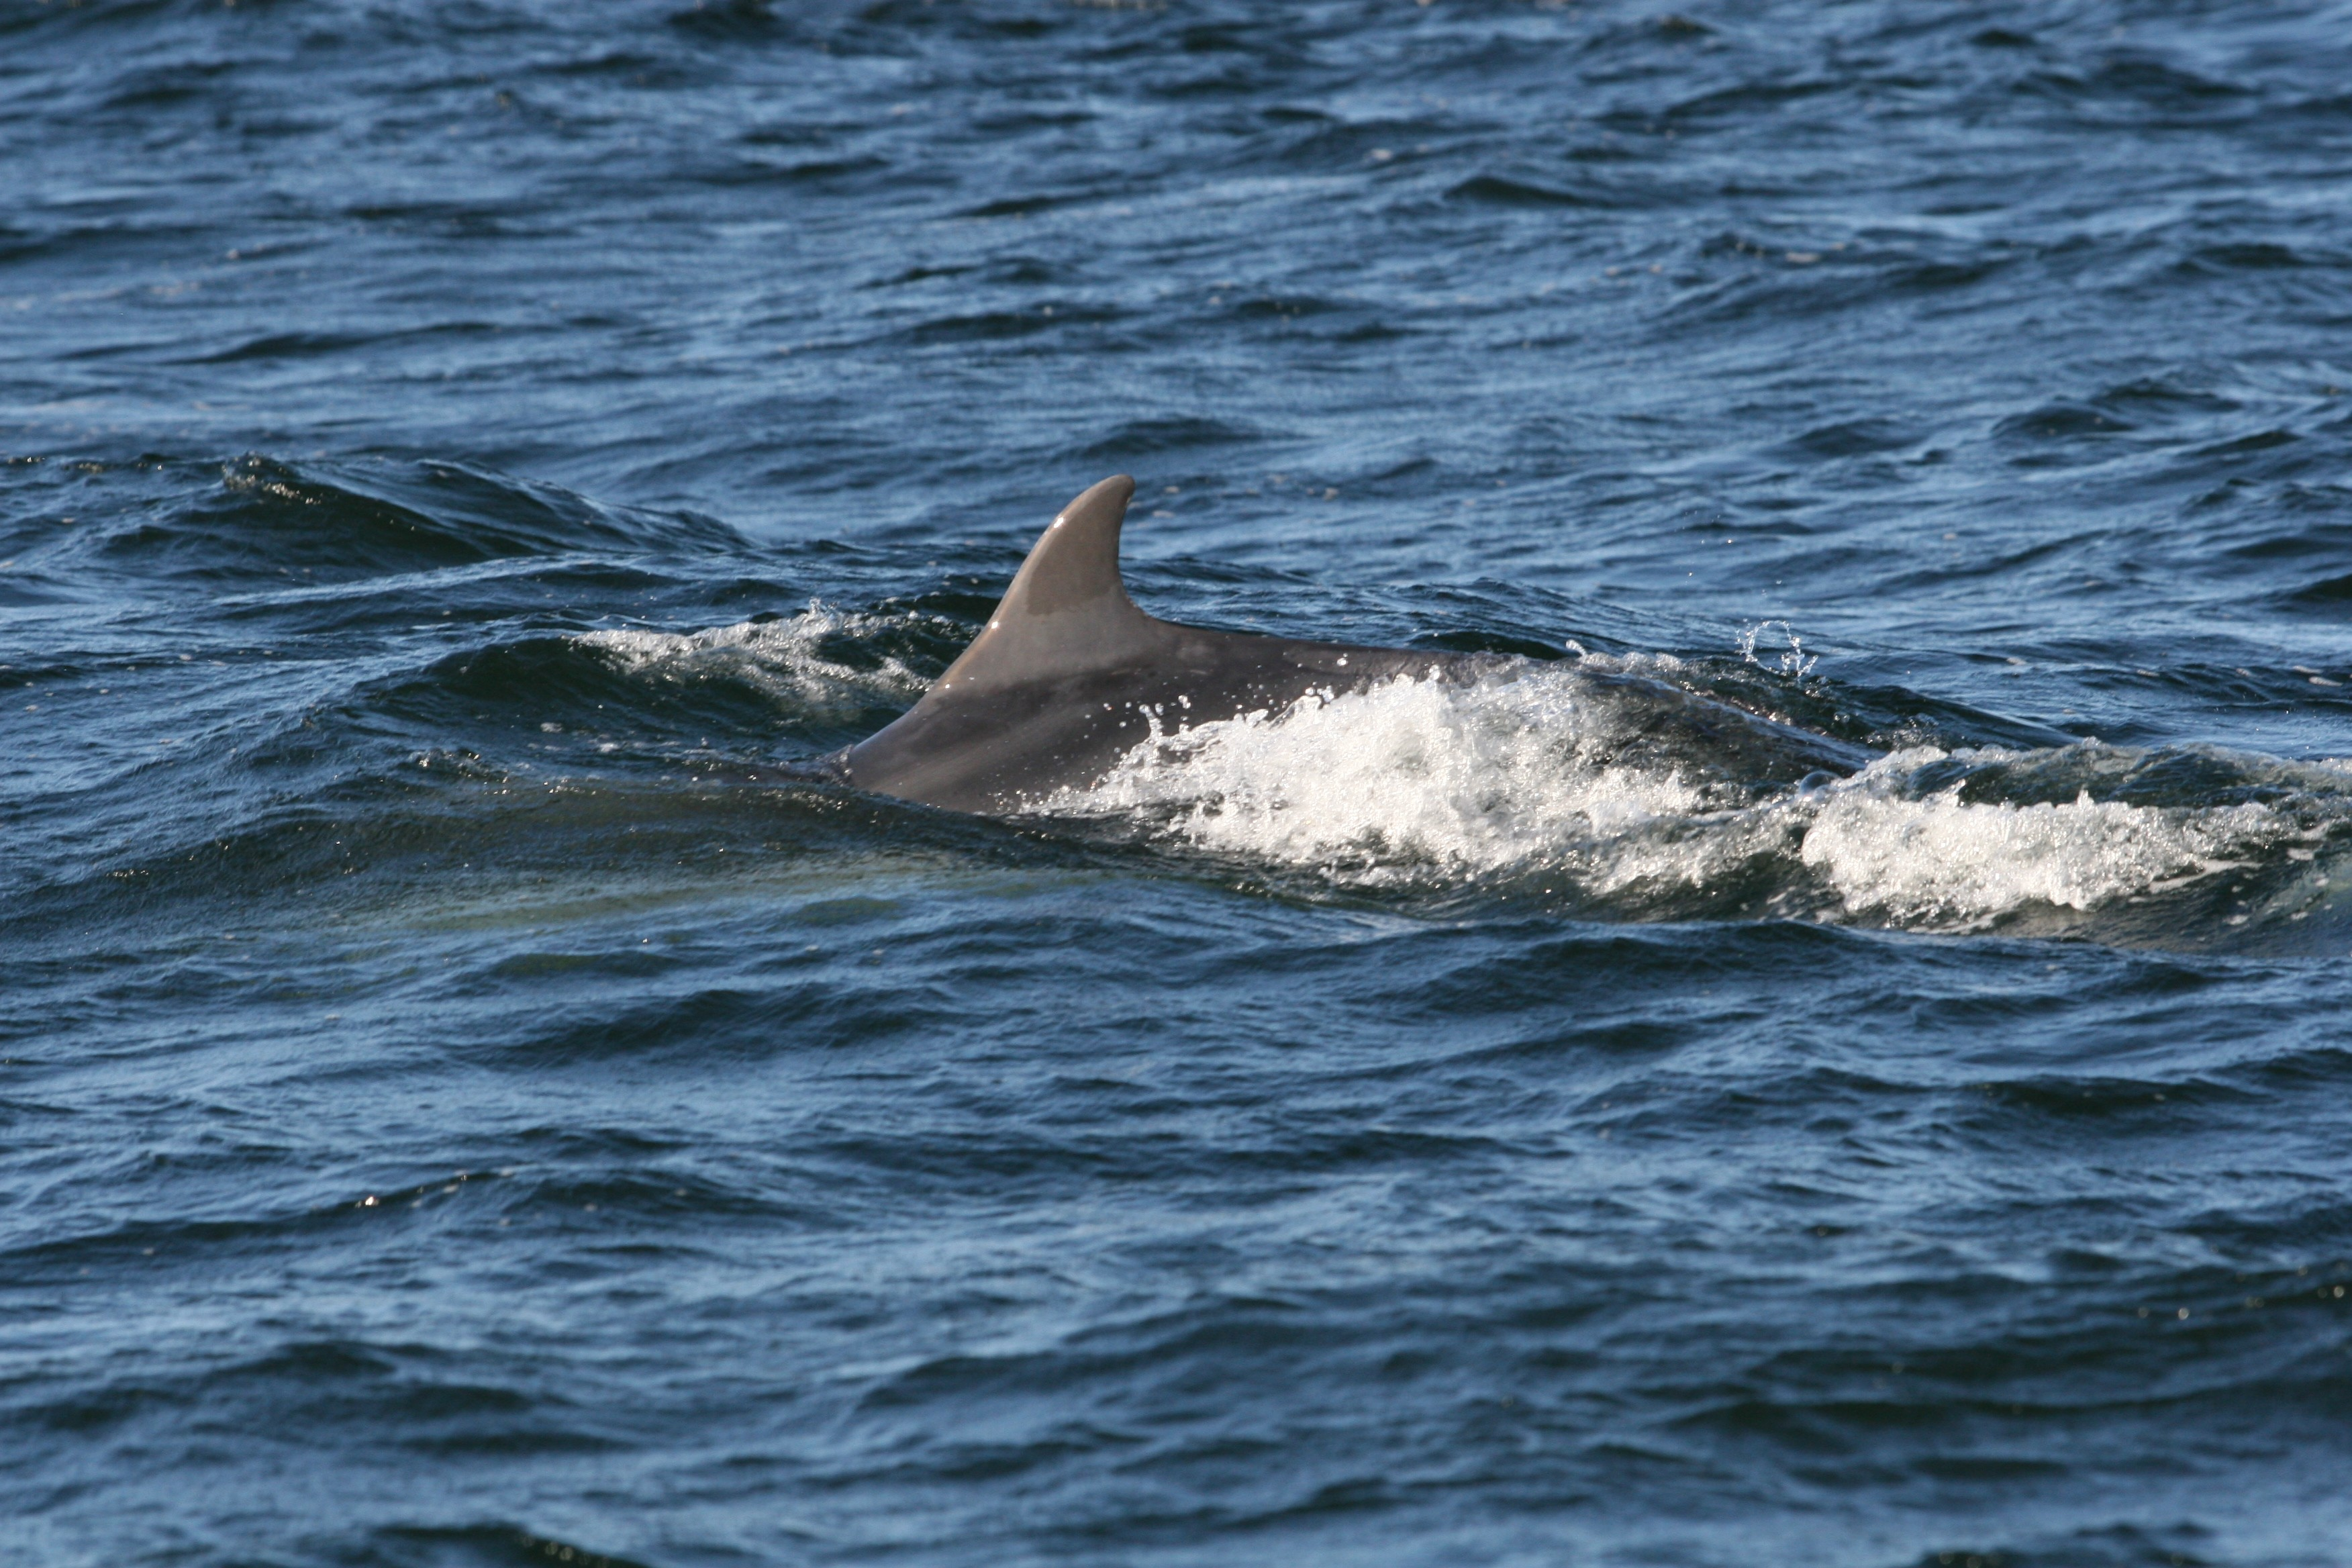

Predicted below: bottlenose_dolphin


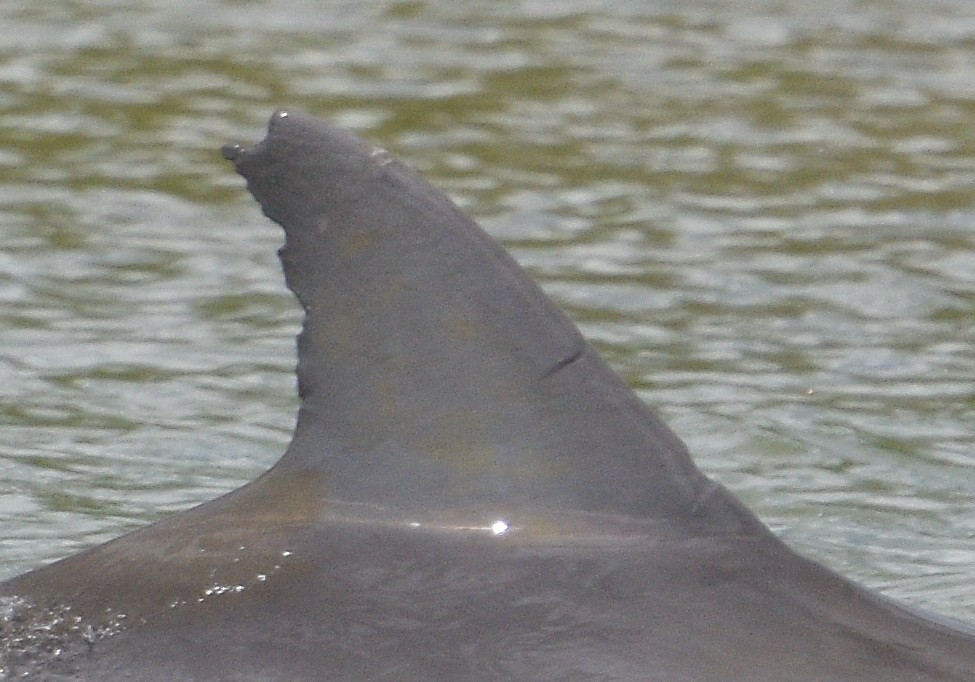

Predicted below: bottlenose_dolphin


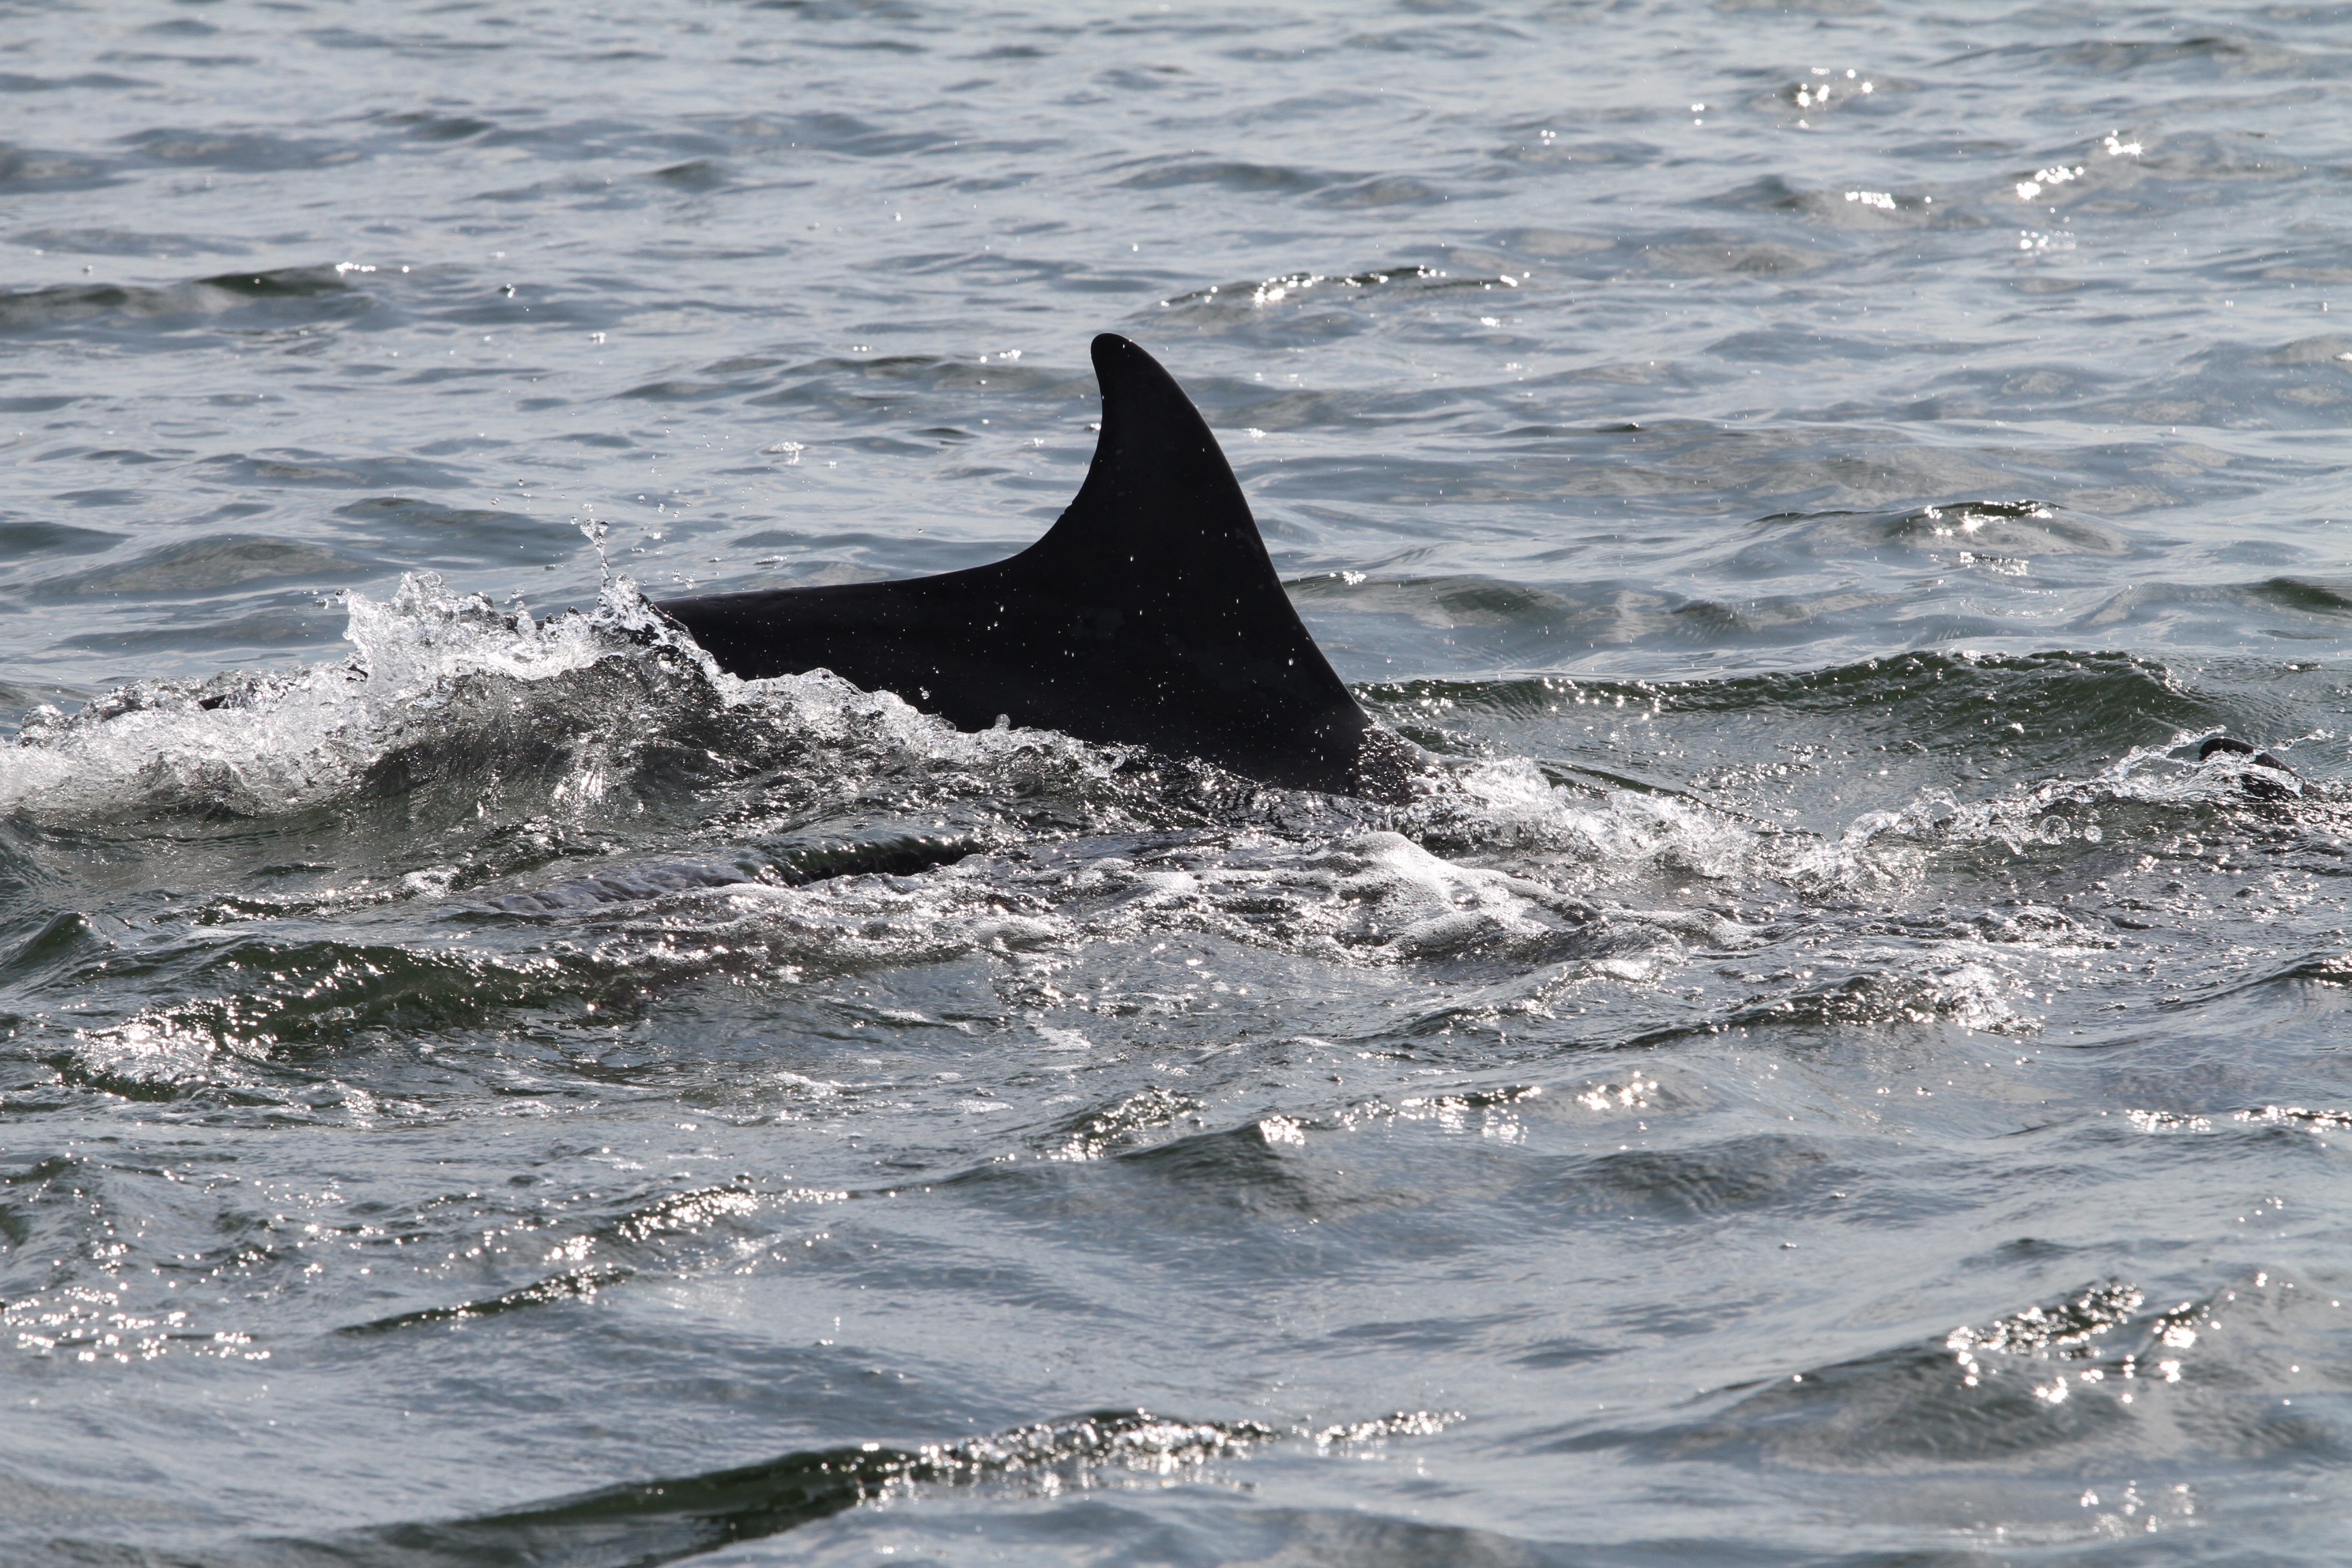

Predicted below: bottlenose_dolphin


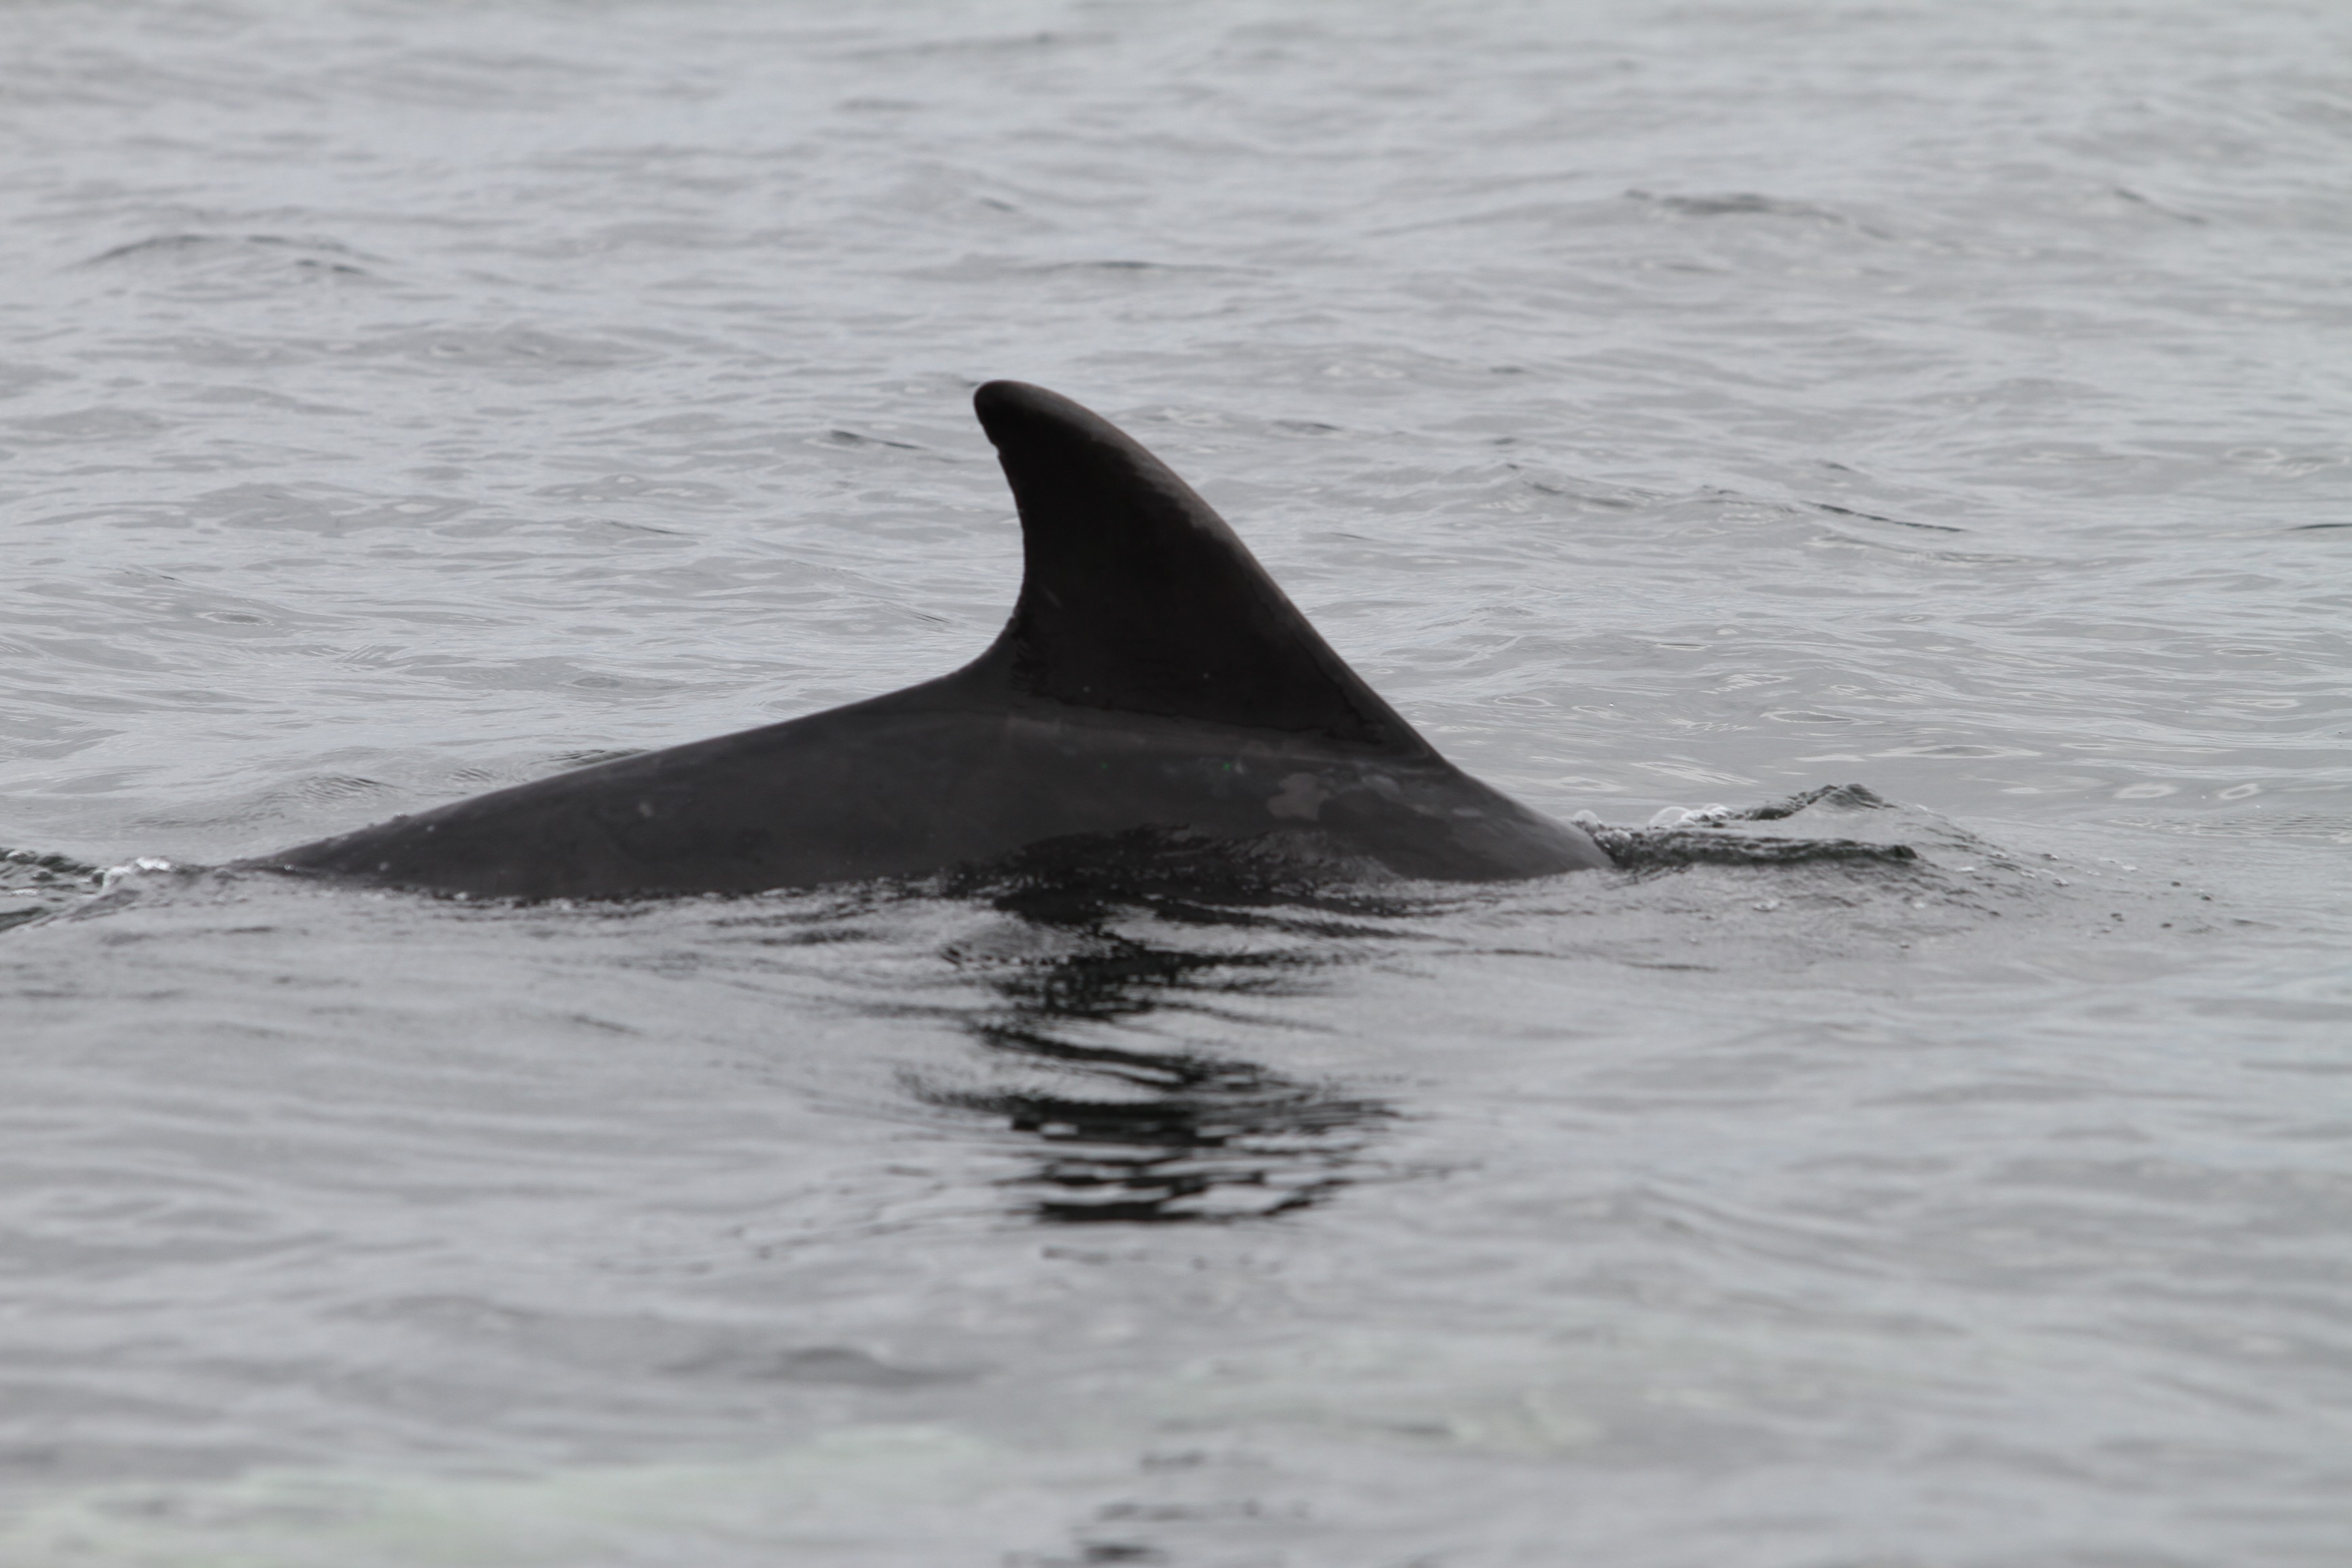

In [10]:
predPath = "predictions/*"
dolphins_whales = np.array(glob("predictions/*"))
for i in range (5):
    print("Predicted below: " + species_dolphin_whale(dolphins_whales[i]))
    display(Image2(filename=dolphins_whales[i], width=256, height=256))
    